In [1]:
%load_ext autoreload
%autoreload 2

# Model concept
![Hallo](..\sample_data\model_concept.drawio.png)

In [2]:
import numpy as np
import pandas as pd
from swmm_api.output_file.extract import SwmmOutExtractWarning
import warnings
from blockage import BlockageSimulation
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=SwmmOutExtractWarning)

# Blockage Simulation Interface
## 1. Define simulation settings

In [3]:
df_defpat = pd.Series(0.9 * np.array([1.4, 0.3, 0.1, 0.0, 0.3, 1.7, 9.1, 21, 13, 9, 6.9, 4.9,
                                       1.9, 3.6, 2.5, 2, 2.9, 2.3, 4.1, 4.0, 2.7, 2.1, 2.2, 2.0]) / 100)
result_path = r"../sample_data/blockage_results.hd5"
settings = dict(model_path = r"..\sample_data\sample_model.inp",
                pop_path = r"../sample_data/pop_data.csv",
                out_path = r"..\sample_data\sample_model.out",
                orifice_path = r"../sample_data/orifice_settings.dat",
                result_path = result_path,
                defpat = df_defpat,
                target_node = "MH3295504178",
                target_link = "MH3295504178.1")

In [4]:
# empty store before simulations
with pd.HDFStore(result_path) as store:
    for key in store.keys():
        store.remove(key)
    print(list(store.keys()))

[]


## 2. Initialize BlockageSimulation

In [5]:
blockage_sim = BlockageSimulation(settings)

## 3. Initial model run

In [6]:
blockage_sim.blank_model_run()

blockage_logger - INFO - creating empty orifice series
blockage_logger - INFO - running hydraulic model


In [7]:
with pd.HDFStore(result_path) as store:
    s = store["/iteration_0"]
s

,orifice,blockage,flow
2015-04-01 00:00:00,1.0,0.0,0.177057
2015-04-01 01:00:00,1.0,0.0,0.456056
2015-04-01 02:00:00,1.0,0.0,0.569973
2015-04-01 03:00:00,1.0,0.0,0.552599
2015-04-01 04:00:00,1.0,0.0,0.550701
...,...,...,...
2015-05-31 20:00:00,1.0,0.0,0.731251
2015-05-31 21:00:00,1.0,0.0,0.728577
2015-05-31 22:00:00,1.0,0.0,0.715550
2015-05-31 23:00:00,1.0,0.0,0.693377


## 3. Initial Routing of packets in hydraulic network

In [8]:
arrivals = blockage_sim.initial_routing()

<Axes: xlabel='MH3295504178', ylabel='passing wipes [#/hr]'>

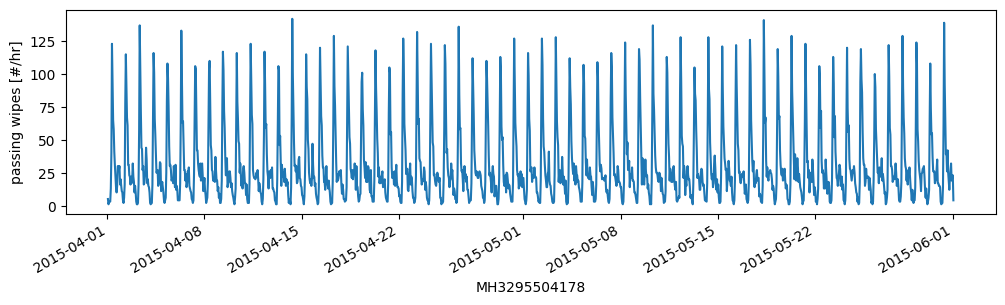

In [9]:
arrivals.plot(figsize=(12, 3), ylabel="passing wipes [#/hr]")

## 3. Get flowrates

In [10]:
s_flowrates = blockage_sim.router.df_flows[blockage_sim.target_link].resample("1h").mean().rename("flow")

<Axes: ylabel='flowrate [l/s]'>

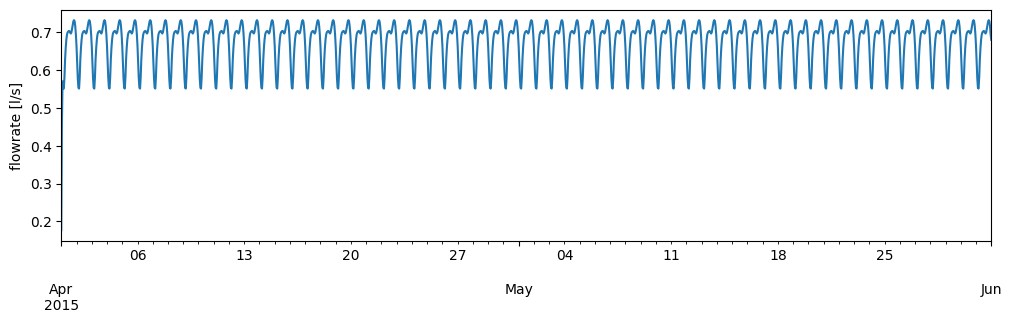

In [11]:
s_flowrates.plot(figsize=(12, 3), ylabel="flowrate [l/s]")

## 4. Simulate snagging and accumulation

In [12]:
# concatenate flowrates and arrivals to common dataframe
df = pd.concat([arrivals, s_flowrates], axis=1)
df["arrivals"].fillna(0, inplace=True)
# sample snagging and accumulating wipes from arriving
df = blockage_sim.sample_accumulation(df)

<Axes: ylabel='accumulation [#/hr]'>

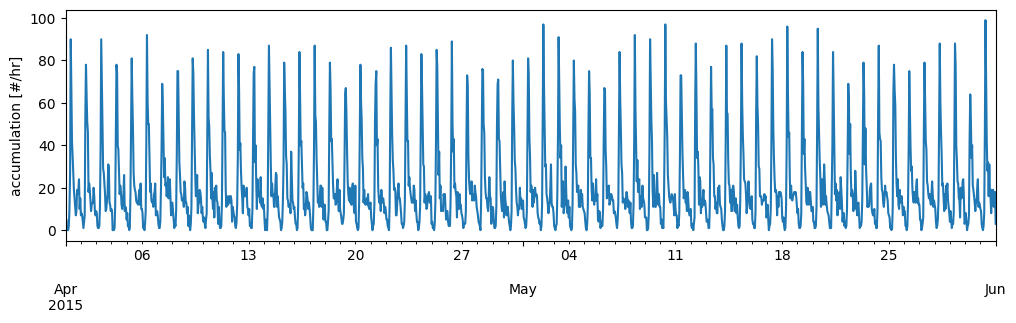

In [13]:
df["accumulation"].plot(figsize=(12, 3), ylabel="accumulation [#/hr]")

## 5. iteratively adapt orifice settings to hydraulic simulation 

In [14]:
df = blockage_sim.run_iterations(df, n_iterations=3, router=blockage_sim.router)

blockage_logger - INFO - starting iteration 1
blockage_logger - INFO - calculating orifice settings
C:\Users\albert\Projekte\ak_local\venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
blockage_logger - INFO - running hydraulic model
blockage_logger - INFO - writing results
blockage_logger - INFO - iteration 1 complete
blockage_logger - INFO - starting iteration 2
blockage_logger - INFO - calculating orifice settings
C:\Users\albert\Projekte\ak_local\venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
blockage_logger - INFO - running hydraulic model
blockage_logger - INFO - writing results
blockage_logger - INFO - iteration 2 complete
blockage_logger - INFO - starting iteration 3
blockage_logger - INFO - calculating orifice settings
C:\Users\albert\Projekte\ak_local\venv\l

In [15]:
result_dict = {}
with pd.HDFStore(result_path) as store:
    for key in store.keys():
        result_dict[key] = store[key]

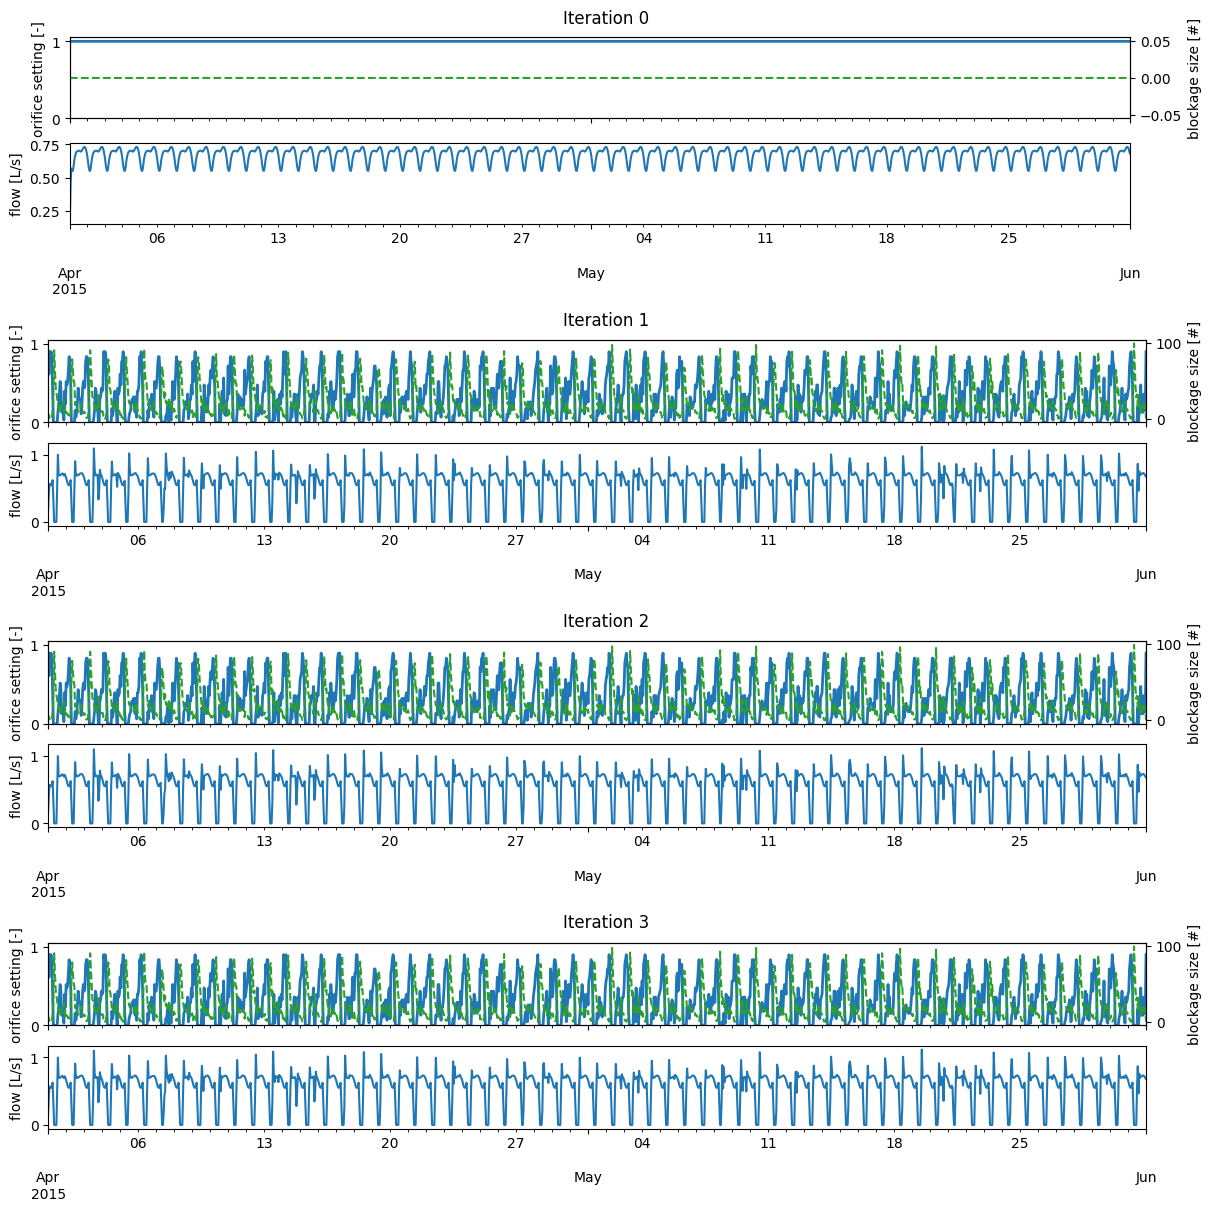

In [16]:
n_iterations = len(result_dict)

fig = plt.figure(layout='constrained', figsize=(12, n_iterations*3))
subfigs = fig.subfigures(nrows=n_iterations, ncols=1)

for i in range(n_iterations):
    subfigs[i].suptitle(f"Iteration {i}")
    df = result_dict[f"/iteration_{i}"]
    axs = subfigs[i].subplots(nrows=2, sharex=True)
    df["orifice"].plot(ax=axs[0], ylim=[0, 1.05], ylabel="orifice setting [-]", lw=2.0)
    ax2 = axs[0].twinx()
    df["blockage"].plot(ax=ax2, ylabel="blockage size [#]", c="tab:green", ls="dashed")
    df["flow"].plot(ax=axs[1], ylabel="flow [L/s]")

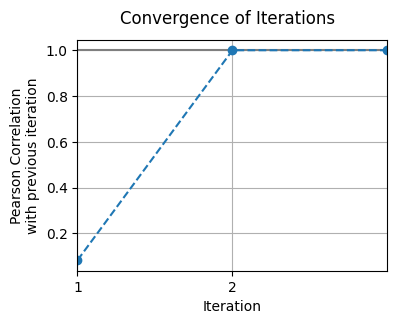

In [48]:
corrs = []
for i in range(1, n_iterations):
    flows1 = result_dict[f"/iteration_{i-1}"]["flow"].rename("old")
    flows2 = result_dict[f"/iteration_{i}"]["flow"].rename("new")
    corrs.append(pd.concat([flows1, flows2], axis=1).corr().loc["old", "new"])

fig, ax = plt.subplots(figsize=[4, 3])
fig.suptitle("Convergence of Iterations")
ax.axhline(1.0, c="tab:grey")
ax.plot(np.arange(1, n_iterations), corrs, marker="o", ls="dashed")
ax.set_xticks(np.arange(n_iterations-1))
ax.set_xlabel("Iteration")
ax.set_ylabel("Pearson Correlation\nwith previous iteration")
ax.set_xlim((1, n_iterations-1))
ax.grid(which="major", axis="both")